In [1]:
# What version python do you have 
import tensorflow.keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time 
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

import scipy.optimize
from scipy.optimize import minimize

check_gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if check_gpu \
      else "NOT AVAILABLE" )

GPU is available


In [2]:
def plot2D(x, y, z, title=None):
    # Graficar
    plt.figure(figsize=(7, 6))
    cp = plt.contourf(x, y, z, cmap='viridis')
    plt.colorbar(cp)
    if title is not None:
        plt.title(title)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.show()

In [3]:
def plot3D(x, y, z):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='b', marker='o', alpha=0.5)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    plt.show()
    return None

In [4]:
DTYPE = 'float64'
tf.keras.backend.set_floatx(DTYPE)

\begin{equation}
    \begin{split}
        \frac{\partial h}{\partial t} & + H \left(\frac{\partial u}{\partial x}
            + \frac{\partial v}{\partial y} \right) = 0, \\
        \frac{\partial u}{\partial t} & - fv = -g \frac{\partial h}{\partial x} - bu, \\
        \frac{\partial v}{\partial t} & + fu = -g \frac{\partial h}{\partial y} - bv.
    \end{split}
\end{equation}

In [5]:
#drive.mount('/content/drive')

In [6]:
#DIR = '/content/drive/MyDrive/Trabajo/Research/PINNs/data/'
#data_dir = DIR + 'swe.npz'
data_dir = 'swe.npz'

In [7]:
data = np.load(data_dir)

In [8]:
t = data['t']
x = data['x'][0]
y = data['y'][:,0]
h = data['h']
u = data['u']
v = data['v']

In [9]:
#x

In [10]:
Nt, Nx, Ny = t.shape[0], x.shape[0], y.shape[0]
x_min, x_max = x[0], x[-1]
y_min, y_max = y[0], y[-1]
t_min, t_max = t[0], t[-1]

In [17]:
# Inside domain
N_f = 8000
# Lower bound
lb = tf.constant([x_min, y_min, t_min], dtype = DTYPE)
# Upper bound
ub = tf.constant([x_max, y_max, t_max], dtype = DTYPE)
# Arrays
x_c = tf.constant(lb[0]+ (ub[0] - lb[0]) * np.random.random(N_f), shape = (N_f, 1), dtype = DTYPE)
y_c = tf.constant(lb[1]+ (ub[1] - lb[1]) * np.random.random(N_f), shape = (N_f, 1), dtype = DTYPE)
t_c = tf.constant(lb[1]+ (ub[2] - lb[2]) * np.random.random(N_f), shape = (N_f, 1), dtype = DTYPE)
# Data inside
X_c = tf.concat([x_c, y_c, t_c], axis = 1)

In [18]:
#X_c

In [100]:
# Boundary
N_b = 2000

# Boundary (x, 0, t) with x in [0, 1]
x_1 = tf.constant(lb[0] + (ub[0] - lb[0]) * np.random.random(N_b), shape = (N_b,1), dtype = DTYPE)
y_1 = tf.zeros(shape = (N_b, 1), dtype = DTYPE)
t_1 = tf.constant(lb[2] + (ub[2] - lb[2]) * np.random.random(N_b), shape = (N_b,1), dtype = DTYPE)
X_b_1 = tf.concat([x_1, y_1, t_1], axis = 1)

# Boundary (1, y, t) with y in [0, 1]
x_2 = tf.ones(shape = (N_b, 1), dtype = DTYPE)
y_2 = tf.constant(lb[1] + (ub[1] - lb[1]) * np.random.random(N_b), shape = (N_b,1), dtype = DTYPE)
t_2 = tf.constant(lb[2] + (ub[2] - lb[2]) * np.random.random(N_b), shape = (N_b,1), dtype = DTYPE)
X_b_2 = tf.concat([x_2, y_2, t_2], axis = 1)

# Boundary (x, 1, t) with y in [0, 1]
x_3 = tf.constant(lb[0] + (ub[0] - lb[0]) * np.random.random(N_b), shape = (N_b,1), dtype = DTYPE)
y_3 = tf.ones(shape = (N_b, 1), dtype = DTYPE)
t_3 = tf.constant(lb[2] + (ub[2] - lb[2]) * np.random.random(N_b), shape = (N_b,1), dtype = DTYPE)
X_b_3 = tf.concat([x_3, y_3, t_3], axis = 1)

# Boundary (0, y, t) with y in [0, 1]
x_4 = tf.zeros(shape = (N_b, 1), dtype = DTYPE)
y_4 = tf.constant(lb[1] + (ub[1] - lb[1]) * np.random.random(N_b), shape = (N_b,1), dtype = DTYPE)
t_4 = tf.constant(lb[2] + (ub[2] - lb[2]) * np.random.random(N_b), shape = (N_b,1), dtype = DTYPE)
X_b_4 = tf.concat([x_4, y_4, t_4], axis = 1)


# Boundary at t =0 (x, y, 0)
#Ns = 32
#xs = np.linspace(x_min, x_max, Ns)
#ys = np.linspace(y_min, y_max, Ns)
#X, Y = np.meshgrid(xs, ys)
#x_0 = tf.constant(X.flatten(), shape = (Ns * Ns, 1), dtype = DTYPE)
#y_0 = tf.constant(Y.flatten(), shape = (Ns * Ns, 1), dtype = DTYPE)
#t_0 = tf.zeros(shape = (Ns * Ns, 1), dtype = DTYPE)
#X_b_0 = tf.concat([x_0, y_0, t_0], axis=1)


N_s = 2000
# Boundary (0, y, t) with y in [0, 1]
x_0 = tf.constant(lb[0] + (ub[0] - lb[0]) * np.random.random(N_s), shape = (N_s,1), dtype = DTYPE)
y_0 = tf.constant(lb[1] + (ub[1] - lb[1]) * np.random.random(N_s), shape = (N_s,1), dtype = DTYPE)
t_0 = tf.zeros(shape = (N_s, 1), dtype = DTYPE)
X_b_0 = tf.concat([x_0, y_0, t_0], axis = 1)


In [101]:
#Grafico Dominio
def plot_3d(azim, elev):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)
    ax.scatter(x_1, y_1, t_1, c='g', label="X_b_1", s=5)
    ax.scatter(x_2, y_2, t_2, c='g', label="X_b_2", s=5)
    ax.scatter(x_3, y_3, t_3, c='g', label="X_b_3", s=5)
    ax.scatter(x_4, y_4, t_4, c='g', label="X_b_4", s=5)
    ax.scatter(x_c, y_c, t_c, c='b', label="X_c", s=5)
    ax.scatter(x_0, y_0, t_0, c='r', label="X_0", s=5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("t")
    ax.set_title("Scatter Plot en R3 de los conjuntos")
    ax.legend()
    ax.grid(True)
    plt.show()

# Deslizadores
azim_slider = widgets.FloatSlider(value=0, min=0, max=360, step=1, description="Azimut:")
elev_slider = widgets.FloatSlider(value=30, min=0, max=90, step=1, description="Elevación:")

widgets.interactive(plot_3d, azim=azim_slider, elev=elev_slider)

interactive(children=(FloatSlider(value=0.0, description='Azimut:', max=360.0, step=1.0), FloatSlider(value=30…

In [102]:
#h0 = lambda x, y: 1 + tf.exp(-((x-0.5) ** 2 + (y-0.5) ** 2) / .01)
#h0 = lambda x, y: 1 +  .1 * tf.cast(tf.sqrt((x - .5)**2 + (y - .5)**2) <= .25, tf.float64) # Con el tf.cast pude cambiar el bool a float :)
#u0 = lambda x, y: x * 0
#v0 = lambda x, y: x * 0

## Condición Inical

In [111]:
#def h_0(X):
#    x, y, t  = X[:,0:1], X[:,1:2], X[:,2:3]
#    return 1.0 +  .1 * tf.sqrt((x - .5)**2 + (y - .5)**2 <= .25)

def h_0(X):
    x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]
    distance = tf.sqrt((x - 0.5)**2 + (y - 0.5)**2)
    return 1.0 + 0.1 * tf.nn.relu(0.25 - distance)


def u_0(X):
    x, y, t  = X[:,0:1], X[:,1:2], X[:,2:3]
    return tf.constant(0.0, dtype = DTYPE)

def v_0(X):
    x, y, t  = X[:,0:1], X[:,1:2], X[:,2:3]
    return tf.constant(0.0, dtype = DTYPE)


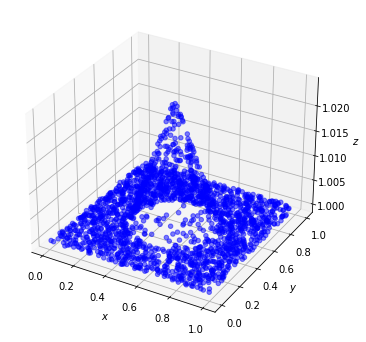

In [112]:
plot3D(X_b_0[:,0:1], X_b_0[:,1:2], h_0(X_b_0))

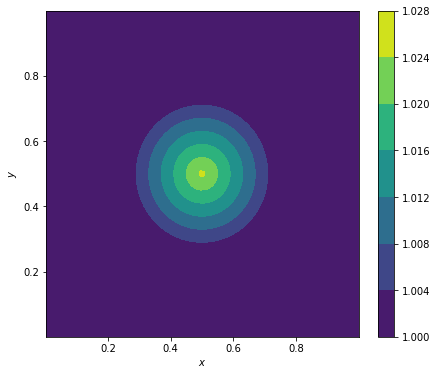

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Suponiendo que X_b_0 y la función h_0 ya están definidas

# Crear una malla de coordenadas 2D
x = np.linspace(np.min(X_b_0[:,0]), np.max(X_b_0[:,0]), 100)
y = np.linspace(np.min(X_b_0[:,1]), np.max(X_b_0[:,1]), 100)
X, Y = np.meshgrid(x, y)

# Evaluar la función h_0 en la malla
Z_tensor = h_0(np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1), np.zeros((X.size, 1))]))
Z = Z_tensor.numpy().reshape(X.shape)  # Convertir a NumPy y cambiar la forma

# Graficar
plt.figure(figsize=(7, 6))
cp = plt.contourf(X, Y, Z, cmap='viridis')
plt.colorbar(cp, extend='both')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()


In [114]:
# PDE
g = 1.0
H = 0.5
b = 2.0
f = 0.0
def PDE(h, u, v, dh_dx, dh_dy, dh_dt, du_dx, du_dy, du_dt, dv_dx, dv_dy, dv_dt):
    PDE1 = dh_dt + H * (du_dx + dv_dy)
    PDE2 = du_dt + g * dh_dx + b * u - f * v
    PDE3 = dv_dt + g * dh_dy + b * v + f * u
    return PDE1, PDE2, PDE3

In [115]:
def get_derivatives(model, X):
    x, y, t  = X[:,0:1], X[:,1:2], X[:, 2:3]
    with tf.GradientTape(persistent = True) as tape:
        tape.watch(x)
        tape.watch(y)
        tape.watch(t)
        h = model(tf.concat([x, y, t], axis = 1))[:, 0:1]
        u = model(tf.concat([x, y, t], axis = 1))[:, 1:2]
        v = model(tf.concat([x, y, t], axis = 1))[:, 2:3]
    dh_dx = tape.gradient(h, x)
    dh_dy = tape.gradient(h, y)
    dh_dt = tape.gradient(h, t)
    du_dx = tape.gradient(u, x)
    du_dy = tape.gradient(u, y)
    du_dt = tape.gradient(u, t)
    dv_dx = tape.gradient(v, x)
    dv_dy = tape.gradient(v, y)
    dv_dt = tape.gradient(v, t)
    return h, u, v, dh_dx, dh_dy, dh_dt, du_dx, du_dy, du_dt, dv_dx, dv_dy, dv_dt

In [116]:
#get_derivatives(nn, X_c)

In [117]:
# Boundary conditions
def boundary_1(model, X):
    h, u, v, dh_dx, dh_dy, dh_dt, du_dx, du_dy, du_dt, dv_dx, dv_dy, dv_dt = get_derivatives(model, X)
    return -dh_dy - 0.0, -du_dy - 0.0, -dv_dy - 0.0

def boundary_2(model, X):
    h, u, v, dh_dx, dh_dy, dh_dt, du_dx, du_dy, du_dt, dv_dx, dv_dy, dv_dt = get_derivatives(model, X)
    return dh_dx - 0.0, du_dx - 0.0, dv_dx - 0.0

def boundary_3(model, X):
    h, u, v, dh_dx, dh_dy, dh_dt, du_dx, du_dy, du_dt, dv_dx, dv_dy, dv_dt = get_derivatives(model, X)
    return dh_dy - 0.0, du_dy - 0.0, dv_dy - 0.0

def boundary_4(model, X):
    h, u, v, dh_dx, dh_dy, dh_dt, du_dx, du_dy, du_dt, dv_dx, dv_dy, dv_dt = get_derivatives(model, X)
    return -dh_dx - 0.0, -du_dx - 0.0, -dv_dx - 0.0

def boundary_conditions(model, X_1, X_2, X_3, X_4):
    b11, b12, b13 = boundary_1(model, X_1)
    b21, b22, b23 = boundary_2(model, X_2)
    b31, b32, b33 = boundary_3(model, X_3)
    b41, b42, b43 = boundary_4(model, X_4)
    return b11, b12, b13, b21, b22, b23, b31, b32, b33, b41, b42, b43


In [118]:
#boundary_conditions(nn, X_b_1, X_b_2, X_b_3, X_b_4)

In [119]:
def custom_loss_r(model, X):
    h, u, v, dh_dx, dh_dy, dh_dt, du_dx, du_dy, du_dt, dv_dx, dv_dy, dv_dt = get_derivatives(model, X)
    phi_r_1, phi_r_2, phi_r_3 = PDE(h, u, v, dh_dx, dh_dy, dh_dt, du_dx, du_dy, du_dt, dv_dx, dv_dy, dv_dt)
    loss_r1 = tf.reduce_mean(tf.square(phi_r_1))
    loss_r2 = tf.reduce_mean(tf.square(phi_r_2))
    loss_r3 = tf.reduce_mean(tf.square(phi_r_3))
    loss_r = loss_r1 + loss_r2 + loss_r3
    return loss_r

In [120]:
#custom_loss_r(nn, X_c)

In [121]:
def custom_loss_m(model, X_1, X_2, X_3, X_4):
    
    b11, b12, b13, b21, b22, b23, b31, b32, b33, b41, b42, b43 = boundary_conditions(model, X_1, X_2, X_3, X_4)
    loss_b_11 = tf.reduce_mean(tf.square(b11))
    loss_b_12 = tf.reduce_mean(tf.square(b12))
    loss_b_13 = tf.reduce_mean(tf.square(b13))
    loss_b_21 = tf.reduce_mean(tf.square(b21))
    loss_b_22 = tf.reduce_mean(tf.square(b22))
    loss_b_23 = tf.reduce_mean(tf.square(b23))
    loss_b_31 = tf.reduce_mean(tf.square(b31))
    loss_b_32 = tf.reduce_mean(tf.square(b32))
    loss_b_33 = tf.reduce_mean(tf.square(b33))
    loss_b_41 = tf.reduce_mean(tf.square(b41))
    loss_b_42 = tf.reduce_mean(tf.square(b42))
    loss_b_43 = tf.reduce_mean(tf.square(b43))
    
    loss_m = loss_b_11 + loss_b_12 + loss_b_13 + loss_b_21 + loss_b_22 + loss_b_23 + loss_b_31 + loss_b_32 + loss_b_33 + loss_b_41 + loss_b_42 + loss_b_43
    return loss_m

In [122]:
def custom_loss_i(model, X_0):
    #x, y, t  = X_0[:,0:1], X_0[:,1:2], X_0[:, 2:3]
    loss_ih = tf.reduce_mean(tf.square(model(X_0)[:, 0:1] - h_0(X_0)))
    loss_iu = tf.reduce_mean(tf.square(model(X_0)[:, 1:2] - u_0(X_0)))
    loss_iv = tf.reduce_mean(tf.square(model(X_0)[:, 2:3] - v_0(X_0)))
    loss_i = loss_ih + loss_iu + loss_iv
    return 100*loss_i

In [123]:
def compute_loss(model, X, X_0, X_1, X_2, X_3, X_4):
    loss_r = custom_loss_r(model, X)
    loss_m = custom_loss_m(model, X_1, X_2, X_3, X_4)
    loss_i = custom_loss_i(model, X_0)
    loss = loss_r + loss_m + loss_i
    return loss, loss_r, loss_m, loss_i

In [124]:
def get_grad_loss(model, X, X_0, X_1, X_2, X_3, X_4):
    with tf.GradientTape(persistent = True) as tape:
        tape.watch(model.trainable_variables)
        loss, loss_r, loss_m, loss_i = compute_loss(model, X, X_0, X_1, X_2, X_3, X_4)
    g = tape.gradient(loss, model.trainable_variables)
    return loss, g, loss_r, loss_m, loss_i

In [125]:
def init_model(num_hidden_layers=5, num_neurons_per_layer=60):
    with tf.device('/cpu:0'):  # Forzar el uso de la CPU
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(3))
        
        for _ in range(num_hidden_layers):
            model.add(tf.keras.layers.Dense(num_neurons_per_layer, 
                                            activation=tf.keras.activations.get('tanh'),
                                            kernel_initializer='he_normal'))  # Cambio a he_normal
        
        model.add(tf.keras.layers.Dense(3))
        
    return model

nn = init_model()
nn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 60)                240       
                                                                 
 dense_31 (Dense)            (None, 60)                3660      
                                                                 
 dense_32 (Dense)            (None, 60)                3660      
                                                                 
 dense_33 (Dense)            (None, 60)                3660      
                                                                 
 dense_34 (Dense)            (None, 60)                3660      
                                                                 
 dense_35 (Dense)            (None, 3)                 183       
                                                                 
Total params: 15,063
Trainable params: 15,063
Non-trai

In [128]:
def init_model(num_hidden_layers=5, num_neurons_per_layer=60):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(3))

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, 
                                        activation=tf.keras.activations.get('tanh'),
                                        kernel_initializer='he_normal'))  # Cambio a he_normal

    model.add(tf.keras.layers.Dense(3))

    return model

nn = init_model()
nn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 60)                240       
                                                                 
 dense_43 (Dense)            (None, 60)                3660      
                                                                 
 dense_44 (Dense)            (None, 60)                3660      
                                                                 
 dense_45 (Dense)            (None, 60)                3660      
                                                                 
 dense_46 (Dense)            (None, 60)                3660      
                                                                 
 dense_47 (Dense)            (None, 3)                 183       
                                                                 
Total params: 15,063
Trainable params: 15,063
Non-trai

In [129]:
#optimizador L-BGFS
def get_weight_tensor(model):
    """Función para devolver las variables actuales del modelo
    como tensor 1D, así como las formas correspondientes en listas."""
    weight_list = []
    shape_list = []
    for v in model.variables:
        shape_list.append(v.shape)
        weight_list.extend(v.numpy().flatten())
    weight_list = tf.convert_to_tensor(weight_list)
    return weight_list, shape_list

def set_weight_tensor(model, weight_list):
    """Función que establece una lista de pesos para las variables en el modelo."""
    idx = 0
    for v in model.variables:
        vs = v.shape
        if len(vs) == 2:  
            sw = vs[0]*vs[1]
            new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
            idx += sw
        elif len(vs) == 1:
            new_val = weight_list[idx:idx+vs[0]]
            idx += vs[0]
        elif len(vs) == 0:
            new_val = weight_list[idx]
            idx += 1
        v.assign(tf.cast(new_val, DTYPE))
        
def get_loss_and_grad(w):
    """Función que proporciona la pérdida actual y el gradiente 
    con respecto a las variables entrenables como vector."""
    set_weight_tensor(nn, w)
    loss, grad_theta, loss_r, loss_m, loss_i  = get_grad_loss(nn, X_c, X_b_0, X_b_1, X_b_2, X_b_3, X_b_4)
    loss = loss.numpy().astype(np.float64)
    grad_flat = []
    for g in grad_theta:
        grad_flat.extend(g.numpy().flatten())
    grad_flat = np.array(grad_flat,dtype=np.float64)
    return loss, grad_flat, loss_r, loss_m, loss_i

In [130]:
#def plot_loss_history(ax=None):
#    if not ax:
#        fig = plt.figure(figsize=(7,5))
#        ax = fig.add_subplot(111)
#    ax.semilogy(range(len(loss_history)), loss_history, 'k-')
#    ax.set_xlabel('$n_{epoch}$')
#    ax.set_ylabel('$\\phi^{n_{epoch}}$')
#    plt.show()
    
def callback(w):
    loss_value, _, loss_r_value, loss_m_value, loss_i_value = get_loss_and_grad(w)
    #loss_history.append(loss_value)
    #hist.append(loss_value)
    #hist_e.append(loss_e_value)
    #hist_m.append(loss_m_value)
    
    loss_hist.append(loss_value)
    loss_r_hist.append(loss_r_value)
    loss_m_hist.append(loss_m_value)
    loss_i_hist.append(loss_i_value)
    if len(loss_hist) % 500 == 0:
        #print(f"Iteration {len(hist)}: Loss = {loss_value:.6e}")
        #print('It {len(hist):05d}: loss = {:10.8e}, loss_e = {:10.8e}, loss_m = {:10.8e}'.format(i, loss, loss_e, loss_m))
        print(f"Iteration {len(loss_hist):05d}: Loss = {loss_value:.6e}, Loss_r = {loss_r_value:.6e}, Loss_m = {loss_m_value:.6e}, Loss_i = {loss_i_value:.6e}")




In [131]:
learning_rate = 0.01
optim = tf.keras.optimizers.Adam(learning_rate)

In [132]:
# Optimizador inicial con tasa de aprendizaje de 0.01


#Actualización de los pesos de model
@tf.function
def train_step(model, X, X_0, X_1, X_2, X_3, X_4):
    loss, grad_theta, loss_r, loss_m, loss_i = get_grad_loss(model, X, X_0, X_1, X_2, X_3, X_4)

    #Realizar paso del descenso de gradiente
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss, loss_r, loss_m, loss_i

In [133]:
#train_step(nn, X_c, X_b_0, X_b_1, X_b_2, X_b_3, X_b_4)

In [134]:
#instanciar modelo
#nn = init_model()

In [135]:
#cargar modelo pre entrenado 
#nn.load_weights('modelo_1_28Oct.h5')

In [136]:
import time

loss_hist = []
loss_r_hist = []
loss_m_hist = []
loss_i_hist = []

In [137]:
# Comienzo del tiempo
t0 = time.time()

N = 20000  # Total de iteraciones

# Función de entrenamiento

for i in range(N+1):
    loss, loss_r, loss_m, loss_i = train_step(nn, X_c, X_b_0, X_b_1, X_b_2, X_b_3, X_b_4)
    loss_hist.append(loss.numpy())
    loss_r_hist.append(loss_r.numpy())
    loss_m_hist.append(loss_m.numpy())
    loss_i_hist.append(loss_i.numpy())

    # Salida después de 500 iteraciones
    if i % 500 == 0:
        print('It {:05d}: loss = {:10.8e}, loss_r = {:10.8e}, loss_m = {:10.8e}, loss_i = {:10.8e}'.format(i, loss, loss_r, loss_m, loss_i))

# Mostrar tiempo de cálculo
print('\nComputation time: {} seconds'.format(time.time()-t0))


InvalidArgumentError: Cannot assign a device for operation sequential_7/dense_42/MatMul/ReadVariableOp: Could not satisfy explicit device specification '' because the node {{colocation_node sequential_7/dense_42/MatMul/ReadVariableOp}} was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=2 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
ReadVariableOp: GPU CPU 
ResourceApplyAdam: CPU 
_Arg: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  sequential_7_dense_42_matmul_readvariableop_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  adam_adam_update_resourceapplyadam_m (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  adam_adam_update_resourceapplyadam_v (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  sequential_7/dense_42/MatMul/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_1/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_2/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_3/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_4/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_5/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_6/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_7/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_8/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_9/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_10/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_11/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_12/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_13/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_14/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_15/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_16/ReadVariableOp (ReadVariableOp) 
  sequential_7/dense_42/MatMul_17/ReadVariableOp (ReadVariableOp) 
  Adam/Adam/update/ResourceApplyAdam (ResourceApplyAdam) /job:localhost/replica:0/task:0/device:GPU:0

	 [[{{node sequential_7/dense_42/MatMul/ReadVariableOp}}]] [Op:__inference_train_step_58414]

In [133]:
#L-BGFS
#20000 iteraciones con optimizador L-BGFS
x0, _ = get_weight_tensor(nn)
       
result = minimize(fun=get_loss_and_grad, x0=x0, jac=True, method='L-BFGS-B', callback=callback, options={'maxiter': 20000, 'maxfun': 50000, 'maxcor': 50, 'maxls': 50, 'ftol': 1.0*np.finfo(float).eps})

set_weight_tensor(nn, result.x)

Iteration 30500: Loss = 1.639326e-03, Loss_r = 7.639137e-04, Loss_m = 9.644662e-05, Loss_i = 7.789662e-04
Iteration 31000: Loss = 1.568741e-03, Loss_r = 7.359355e-04, Loss_m = 9.618921e-05, Loss_i = 7.366163e-04
Iteration 31500: Loss = 1.498061e-03, Loss_r = 7.036533e-04, Loss_m = 9.026467e-05, Loss_i = 7.041428e-04
Iteration 32000: Loss = 1.431043e-03, Loss_r = 6.725443e-04, Loss_m = 8.819291e-05, Loss_i = 6.703053e-04
Iteration 32500: Loss = 1.372480e-03, Loss_r = 6.494693e-04, Loss_m = 8.702970e-05, Loss_i = 6.359810e-04
Iteration 33000: Loss = 1.318218e-03, Loss_r = 6.202775e-04, Loss_m = 8.052499e-05, Loss_i = 6.174159e-04
Iteration 33500: Loss = 1.263481e-03, Loss_r = 6.006497e-04, Loss_m = 8.091194e-05, Loss_i = 5.819195e-04
Iteration 34000: Loss = 1.217237e-03, Loss_r = 5.765113e-04, Loss_m = 7.693186e-05, Loss_i = 5.637935e-04
Iteration 34500: Loss = 1.166887e-03, Loss_r = 5.583321e-04, Loss_m = 7.546491e-05, Loss_i = 5.330903e-04
Iteration 35000: Loss = 1.120209e-03, Loss_r =

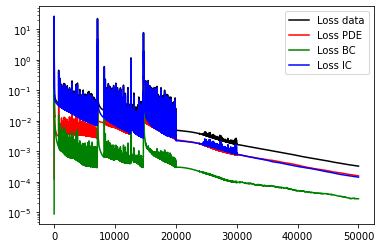

In [134]:
# Loss plot
fig, ax = plt.subplots()
ax.plot(loss_hist, c='k', label='Loss data')
ax.plot(loss_r_hist, c='r', label='Loss PDE')
ax.plot(loss_m_hist, c='g', label='Loss BC')
ax.plot(loss_i_hist, c='b', label='Loss IC')
ax.set_yscale('log')
ax.legend()
plt.savefig('loss_plot.png')
plt.show()

In [135]:
n = 0 # Time step to evaluate
te = t[n] # time evaluation
print(te)

# Crear una malla para x, y
xp = np.linspace(0, 1, 100)
yp = np.linspace(0, 1, 100)
x_grid, y_grid = np.meshgrid(xp, yp)

# Crear el tensor X para evaluación en t=1 y z=0
X_eval = np.stack([x_grid.flatten(), y_grid.flatten(), te  + np.zeros_like(x_grid.flatten())], axis=1) # , np.full_like(x_grid.flatten(), 1)

# Evaluar el modelo
# model_values = model_eval(tf.constant(X_eval, dtype=tf.float32)).numpy()
# model_values = model_values.reshape(x_grid.shape)
model_predict = nn(tf.constant(X_eval, dtype=tf.float64)).numpy()
h_predict = model_predict[:, 0:1].reshape(x_grid.shape)
u_predict = model_predict[:, 1:2].reshape(x_grid.shape)
v_predict = model_predict[:, 2:3].reshape(x_grid.shape)

0.0


In [136]:
#model_predict

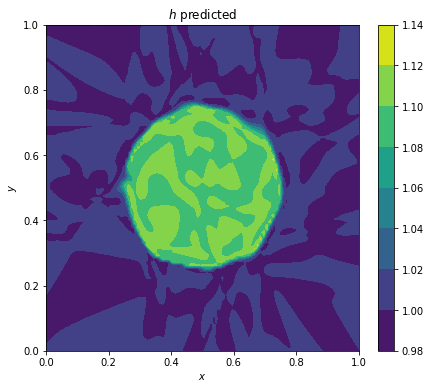

In [137]:
plot2D(x_grid, y_grid, h_predict, r'$h$ predicted')

In [138]:
#nn.save('exp_2modelo_1_28Oct.h5')

In [139]:
#plot2D(x, y, h[n], r'$h$')

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Suponiendo que t, nn y otras variables necesarias ya están definidas en el contexto previo

def plot_h_predict(n):
    # Evaluación en el tiempo
    te = t[n]
    
    # Crear una malla para x, y
    xp = np.linspace(0, 1, 100)
    yp = np.linspace(0, 1, 100)
    x_grid, y_grid = np.meshgrid(xp, yp)

    # Crear el tensor X para evaluación
    X_eval = np.stack([x_grid.flatten(), y_grid.flatten(), te + np.zeros_like(x_grid.flatten())], axis=1)

    # Evaluar el modelo
    model_predict = nn(tf.constant(X_eval, dtype=tf.float64)).numpy()
    h_predict = model_predict[:, 0:1].reshape(x_grid.shape)

    # Graficar h_predict
    plt.figure(figsize=(8, 6))
    plt.contourf(x_grid, y_grid, h_predict, levels=50, cmap='jet')
    plt.colorbar(label='h_predict')
    plt.title(f'h_predict en el tiempo t = {te:.2f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Crear un deslizador interactivo para n
interact(plot_h_predict, n=IntSlider(min=0, max=len(t)-1, step=1, value=0))



interactive(children=(IntSlider(value=0, description='n', max=500), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_h_predict(n)>

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from mpl_toolkits.mplot3d import Axes3D  # Importar para gráficos 3D
import tensorflow as tf

# Suponiendo que t, nn y otras variables necesarias ya están definidas en el contexto previo

# Determinar los límites de color para el colormap basados en los datos en n=0
n_initial = 0
te_initial = t[n_initial]
X_eval_initial = np.stack([x_grid.flatten(), y_grid.flatten(), te_initial + np.zeros_like(x_grid.flatten())], axis=1)
model_predict_initial = nn(tf.constant(X_eval_initial, dtype=tf.float64)).numpy()
h_predict_initial = model_predict_initial[:, 0:1].reshape(x_grid.shape)
vmin, vmax = h_predict_initial.min(), h_predict_initial.max()

def plot_h_predict(n):
    # Evaluación en el tiempo
    te = t[n]
    
    # Crear una malla para x, y
    xp = np.linspace(0, 1, 100)
    yp = np.linspace(0, 1, 100)
    x_grid, y_grid = np.meshgrid(xp, yp)

    # Crear el tensor X para evaluación
    X_eval = np.stack([x_grid.flatten(), y_grid.flatten(), te + np.zeros_like(x_grid.flatten())], axis=1)

    # Evaluar el modelo
    model_predict = nn(tf.constant(X_eval, dtype=tf.float64)).numpy()
    h_predict = model_predict[:, 0:1].reshape(x_grid.shape)

    # Graficar h_predict como una superficie
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')  # Crear un eje 3D
    surf = ax.plot_surface(x_grid, y_grid, h_predict, cmap='jet', edgecolor='none', vmin=vmin, vmax=vmax)
    fig.colorbar(surf, shrink=0.5, aspect=5, label='h_predict')
    ax.set_title(f'h_predict en el tiempo t = {te:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('h_predict')

    # Fijar los límites del eje z
    ax.set_zlim([0.97, 1.1])

    plt.show()

# Crear un deslizador interactivo para n
interact(plot_h_predict, n=IntSlider(min=0, max=len(t)-1, step=1, value=0))



interactive(children=(IntSlider(value=0, description='n', max=500), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_h_predict(n)>

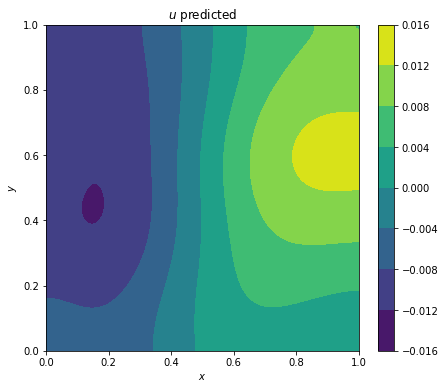

In [179]:
plot2D(x_grid, y_grid, u_predict, r'$u$ predicted')

In [132]:
plot2D(x, y, u[b], r'$u$')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices